### Analyzing the best solutions found

| Experiment ID | Min DF | Binary | Vectorizer | Method | Best k |
|---------------|--------|--------|------------|--------|--------|
| 1463          | 0.35   | True   | NCut       | NMF    | 7      |
| 26            | 0.05   | True   | Count      | LDA    | 12     |
| 24            | 0.05   | True   | Count      | NMF    | 15     |

#### Import libraries

In [29]:
#DB
from questions.models import Solution, Cluster
import psycopg2
from django.conf import settings

# Helpers
import numpy as np
import pickle
import base64
import pandas as pd

# Preprocessing
import tokenize
from tokenizer import create_bag_of_words
from sklearn.feature_extraction.text import CountVectorizer
from vectorizer import NCutVectorizer

# Distance
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, pairwise_kernels

# Learning
from clustering import Clustering
from questions.sampling import get_next_sample
from analyzer import python_analyzer

# Visualization
from plot2d import Plot2D
import matplotlib.pyplot as plt
import seaborn as sns
# from generate_pdf import PDFReport
import pyLDAvis.sklearn
import matplotlib.patches as patches


%matplotlib inline

In [28]:
## Cleaning database
last_id = 132

problems = Problem.objects.filter(id__lte=last_id)
print("Problems to be used: %d" % problems.count())

solutions_obj = Solution.objects.filter(problem__in=problems, ignore=False).order_by('id')
# solutions_obj = Solution.objects.all().order_by('id')
print("Solutions to be used: %d" % solutions_obj.count())

docs_id = []
questions = []
solutions = []

# Fill separated structures
for sol in solutions_obj:
    docs_id.append(sol.id)
    questions.append(sol.problem.content)
    solutions.append(sol.content)

print("Got %d documents" %(solutions_obj.count()))

Problems to be used: 132
Solutions to be used: 54
Got 54 documents


***Limitações do parser:***

***1. Variável e nome reservado são do mesmo tipo. Não consigo separar sem fazer uma pré-lista. Mas pode ser o critério para ajustar o CountVectorizer***

***2. Não é possível processar solução sintaticamente errada. Talvez uma tokenização básica possa ajudar quando esse for o caso e já é uma indicação de que está errado.***

# Connect to DB

In [31]:
connection = psycopg2.connect(user = settings.DATABASES["default"]["USER"],
                                  password = settings.DATABASES["default"]["PASSWORD"],
                                  host = settings.DATABASES["default"]["HOST"],
                                  port = settings.DATABASES["default"]["PORT"],
                                  database = settings.DATABASES["default"]["NAME"])
connection.autocommit=True
cursor = connection.cursor()

In [32]:
def get_where_items(exp_id):
    cols = ["vectorizer", "min_df", "is_binary", "distance", "method", "dataset", "k", "model", "X"]
    query = "SELECT %s from experiments_solution where experiment_id = %s" % (", ".join(cols), exp_id) 
    cursor.execute(query)
    where_items = cursor.fetchall()
    return where_items

def analyze(solutions, where_items, exp_id):
    v = eval(where_items[0][0])
    m = where_items[0][1]
    b = where_items[0][2]
    dist = where_items[0][3]
    method = where_items[0][4]
    k = where_items[0][6]
    model_db = pickle.loads(base64.b64decode(where_items[0][7]))
    X = np.asarray(where_items[0][8])

    train_data_features, vectorizer, feature_names = create_bag_of_words(solutions, v, binary=b, min_df=m)
    clustering = Clustering(train_data_features, k, metric=dist)
    clustering.seed = model_db.random_state
    
    model, document_topic, word_topic = getattr(clustering, method)()
    
    savefig='problems_20190101_%s_%s_exp_%s_%s_document_topic_distribution' % (method, clustering.seed, 
                                                                                   exp_id, clustering.k)
    clustering.plot_topic_distribution(title="Topic distribution per document", ylabel="Document ID", savefig=savefig, cmap='Blues')

    print("Count per class:")
    clusters = clustering.document_topic.argmax(axis=1)
    counts = np.unique(clusters, return_counts=True)
    print(counts)
    return clustering, method, feature_names, model

#### Visualization
Reduce to 2 dimensions

In [33]:
def plot_reduction(clustering, method, exp_id):
    cluster_names = ["Topic %d" % (i+1) for i in range(clustering.k)]
    doc_category = ["Topic %d" % (i+1) for i in clustering.document_topic.argmax(axis=1)]
    doc_category = ["Topic %d" % (i+1) for i in clustering.document_topic.argmax(axis=1)]
    handler = Plot2D(clusters=cluster_names, doc_category=doc_category, doc_id=docs_id)
    handler._generate_random_state()
    solution_sample = clustering.X

    # Reduce using PCA
    handler.reduce_pca(solution_sample)
#     print(handler.seed)
    handler.plot(show_clusters=True, savefig='problems_20190101_%s_%s_exp_%s_%s_pca' % (method, clustering.seed,
                                                                                         exp_id, clustering.k))

    # Reduce using SVD
    handler.reduce_svd(solution_sample)
#     print(handler.seed)
    handler.plot(show_clusters=True, savefig='problems_20190101_%s_%s_exp_%s_%s_svd' % (method, clustering.seed,
                                                                                         exp_id, clustering.k))

    # Reduce using TSNE
    handler.reduce_tsne(solution_sample)
#     print(handler.seed)
    handler.plot(show_clusters=True, savefig='problems_20190101_%s_%s_exp_%s_%s_tsne' % (method, clustering.seed,
                                                                                         exp_id, clustering.k))

    # Reduce using MDS
    handler.reduce_mds(solution_sample)
#     print(handler.seed)
    handler.plot(show_clusters=True, savefig='problems_20190101_%s_%s_exp_%s_%s_mds' % (method, clustering.seed,
                                                                                         exp_id, clustering.k))

    sample = handler.X
    y = clustering.document_topic.argmax(axis=1)
    return sample, y

#### Generate PDF report

In [35]:
# def pdf(sample, y, clustering, method, exp_id):
#     # Create X as an empty belief state (X is the machine's model of the student's distribution)
#     X = np.zeros(clustering.document_topic.shape) # nS x nC
#     print(X.shape)

#     # Create Y as a document_topic matrix. For the first version, each document belongs to one topic
#     Y_col = clustering.document_topic.argmax(axis=1) # nS x nC
#     Y = np.zeros(clustering.document_topic.shape)
#     for idx in range(Y.shape[0]):
#         Y[idx, Y_col[idx]] = 1

#     # Create W as a similarity matrix
#     W = cosine_similarity(clustering.X) # nS x nS
#     print(W.shape)

#     with open('similarity.pkl', 'wb') as picklefile:
#         pickle.dump(W, picklefile)

#     # Set L as an unlabelled set
#     L = []
    
#     doc = PDFReport()
    
#     for i in range(54):
#         # Plot sample
#         sample_id = get_next_sample(X, Y, W, L)

#         # Print question
#         problem = "Cluster: " + str(y[sample_id] + 1) + "\n" + questions[sample_id]
#         solution = solutions[sample_id]

#         # Plot sample
#         fig = plt.figure(figsize=(9,13))

#         # Get the total number of samples (nS) and total number of classes (nC). nC is not actually used.
#         [nS, nC] = X.shape
#         # Create the set of unlabelled samples (U)
#         U = np.setdiff1d(np.arange(nS), L)

#         # Plot unlabeled samples
#         plt.scatter(x=sample[U,0], y=sample[U,1], s=100)

#         # Color by class the ones already labeled
#         if L:
#             a = plt.scatter(x=sample[L,0], y=sample[L,1], c=y[L], s=100)

#         # Star the queried sample
#         plt.scatter(x=sample[sample_id,0], y=sample[sample_id,1], color='r', marker=r'$\star$', s=400)

#         # Save figure
#         plt.savefig("images/solution_%d.eps" % sample_id, format='eps')
#         plt.savefig("images/solution_%d.png" % sample_id, format='png')
#         plt.close(fig)
#     #     print("Question %d" % sample_id)

#         # Print question
#     #     problem = questions[sample_id]
#     #     solution = solutions[sample_id]

#         # Suppose that the student gets it correctly
#         # Update X matrix
#         X[sample_id] = Y[sample_id]
#         L.append(sample_id)
#         doc.append_solution(sample_id, problem, solution)
#     #     print(X)

#     doc.generate_tex("problems_20190101_%s_%s_exp_%s_%s" % (method, clustering.seed, 
#                                                                     exp_id, clustering.k))

#### Words per topic

In [36]:
def normalize_per_row(matrix):
    row_sums = matrix.sum(axis=0)
    matrix_norm = matrix / row_sums[np.newaxis, :]
    return matrix_norm

def sort_distribution(df, columns, MIN_PROB=0.3):
    ids = []

    for col in columns:
        ids = ids + df[df[col] > MIN_PROB].sort_values([col], ascending=False).index.tolist()
    
    for col in columns:
        ids = ids + df.sort_values([col], ascending=False).index.tolist()

    index = df.loc[ids].index.drop_duplicates()
    df_sorted = df.loc[index]
    return df_sorted

def plot_words_per_topic(clustering, feature_names, exp_id, topics=None, size=200, figsize=(8,18), cutoff=False, 
                         ylabel=True, mark_exclusive=False):
    # word_topic_norm = normalize_per_row(word_topic)
    
    x = ["Topic %d" % (idx+1) for idx in range(clustering.document_topic.shape[1])]
    y = feature_names
    word_topic_df = pd.DataFrame(clustering.word_topic, index=y, columns=x)
    if topics:
        x = ["Topic %d" % (idx+1) for idx in topics]
        word_topic_df = word_topic_df[x]
    
    # word_topic_df = pd.DataFrame(word_topic_norm, index=y, columns=x)
    
    avg_weight = np.percentile(clustering.word_topic, 75)
    word_topic_df = sort_distribution(word_topic_df, x, MIN_PROB=avg_weight)
    
    if cutoff:
        word_topic_df['keep'] = word_topic_df.apply(lambda row: not all([(x < 1) for x in row]), axis = 1)
        word_topic_df = word_topic_df[word_topic_df['keep'] == True]
        word_topic_df.drop('keep', inplace=True, axis=1)
        
    plt.figure(figsize=figsize)

    points = word_topic_df.values
    cols = word_topic_df.columns
    rows = word_topic_df.index

    plt.xticks(range(0,len(cols)), cols, fontsize=16)
    if ylabel:
        plt.yticks(range(0,len(rows)), rows, fontsize=18)
    else:
        plt.yticks(range(0,len(rows)), '')
        
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        bottom=False,      # ticks along the bottom edge are off
        top=True,         # ticks along the top edge are off
        labelbottom=False,
        labeltop=True)
    plt.grid(alpha=0.3)

    for x_item in range(len(cols)):
        for y_item in range(len(rows)): 
            
            if points[y_item, x_item] > avg_weight:
                
                # Get terms that are exclusive for the given topic
                exclusive = []
                for x_item_comp in range(len(cols)):
                    if x_item != x_item_comp and points[y_item, x_item_comp] <= avg_weight:
                        exclusive.append('g')       
                if mark_exclusive and len(exclusive) == (len(cols)-1):
                    c = 'g'
                else:
                    c = 'r'
                
            else:
                c = 'b'
            plt.scatter(x_item, y_item, s=points[y_item, x_item]*size, c=c)

    plt.gca().invert_yaxis()
#     plt.yticks(rotation='45')
    plt.xticks(rotation='45')
    
#     # Create a Rectangle patch
#     rect = patches.Rectangle((1.5,8.5),2,11,linewidth=10,edgecolor='gray',facecolor='none')
#     # Add the patch to the Axes
#     plt.gca().add_patch(rect)

    
    plt.tight_layout()
    if mark_exclusive:
        plt.savefig('images/problems_20190101_%s_%s_exp_%s_word_topic_exclusive.png' % (method, clustering.seed, exp_id))
        plt.savefig('images/problems_20190101_%s_%s_exp_%s_word_topic_exclusive.eps' % (method, clustering.seed, exp_id), format='eps')
    else:
        plt.savefig('images/problems_20190101_%s_%s_exp_%s_word_topic.png' % (method, clustering.seed, exp_id))
        plt.savefig('images/problems_20190101_%s_%s_exp_%s_word_topic.eps' % (method, clustering.seed, exp_id), format='eps')
    plt.show()
    
def print_top_words(model, feature_names, n_top_words):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        names = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        top_words.append(names)
        message += ", ".join(names)
        print(message)
    print()
    return top_words

#### pyLDAvis

In [37]:
def LDAvis(solutions, where_items, model, R=0):
    v = eval(where_items[0][0])
    m = where_items[0][1]
    b = where_items[0][2]
    dist = where_items[0][3]
    method = where_items[0][4]
    k = where_items[0][6]
    model_db = pickle.loads(base64.b64decode(where_items[0][7]))
    X = np.asarray(where_items[0][8])

    vectorizer = CountVectorizer(analyzer = python_analyzer,
                                 binary=b,
                                 min_df=m)
    train_data_features = vectorizer.fit_transform(solutions)
 
    pyLDAvis.enable_notebook()
    panel = pyLDAvis.sklearn.prepare(model, train_data_features, vectorizer, mds='pcoa', sort_topics=False, R=R)
    return panel

# Experiment 1463

- Min DF: 0.35
- Binary: True
- Vectorizer: NCut
- Method: NMF
- Best k: 7

Conditions
('NCutVectorizer', 0.35, True, 'euclidean', 'nmf', 'solution_all', 7)


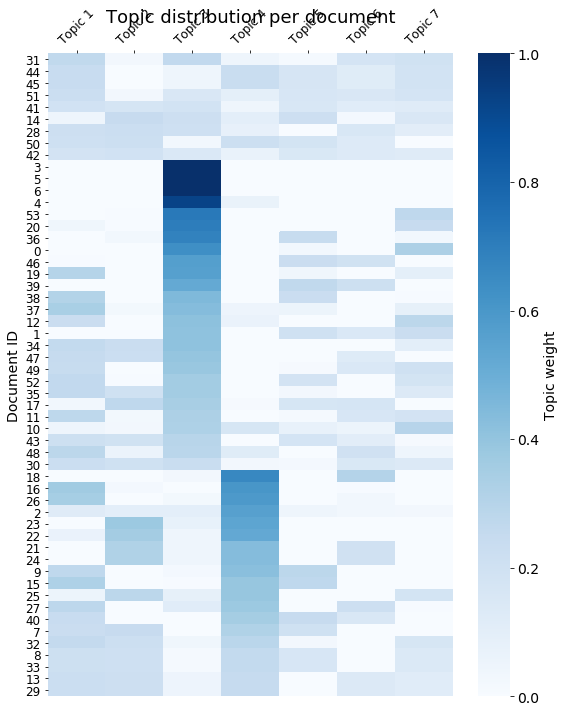

Count per class:
(array([0, 1, 2, 3]), array([ 5,  4, 26, 19]))
Number of terms: 23


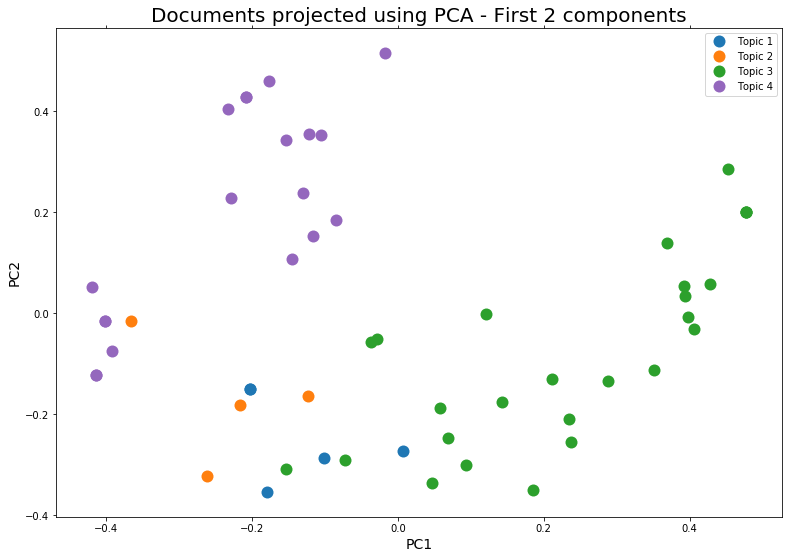

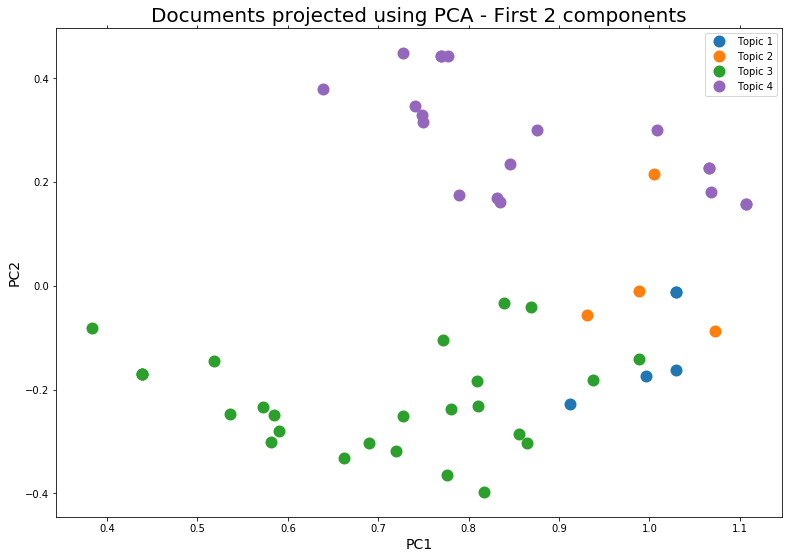

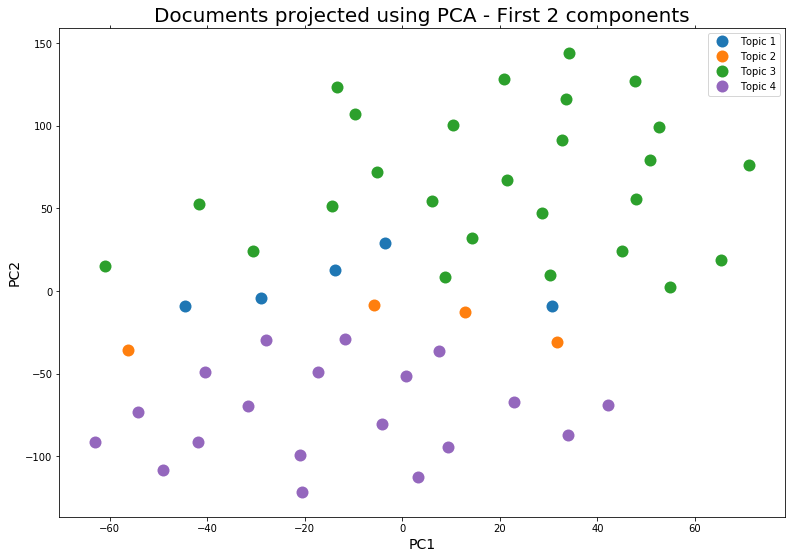

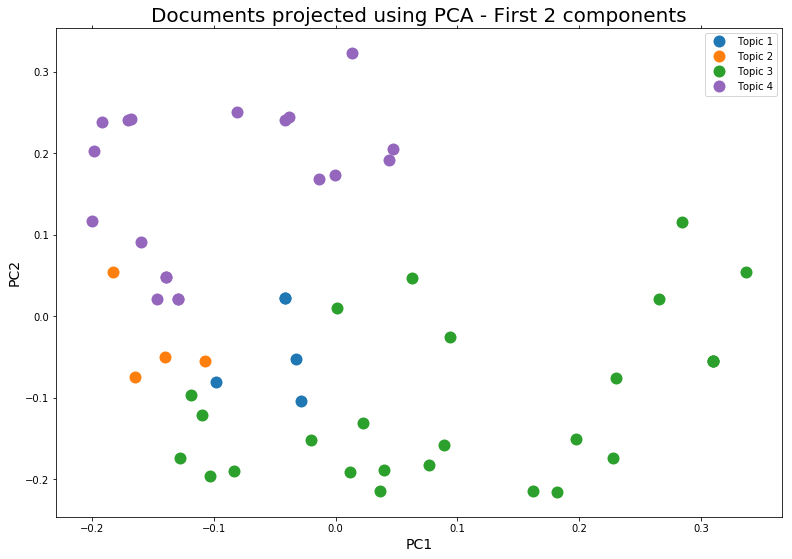

(54, 7)
(54, 54)


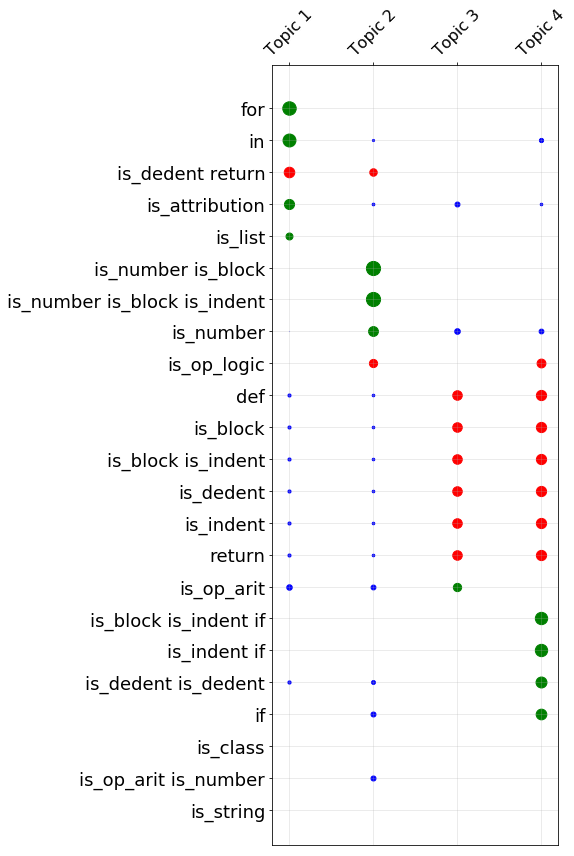

Topic #0: for, in, is_dedent return, is_attribution, is_list, is_op_arit, is_dedent is_dedent, return, is_indent, is_dedent
Topic #1: is_number is_block is_indent, is_number is_block, is_number, is_op_logic, is_dedent return, is_op_arit is_number, if, is_op_arit, is_dedent is_dedent, is_attribution
Topic #2: def, is_indent, is_block, is_block is_indent, is_dedent, return, is_op_arit, is_number, is_attribution, is_number is_block
Topic #3: is_indent if, is_block is_indent if, is_dedent is_dedent, if, return, is_block, is_block is_indent, is_dedent, is_indent, def
Topic #4: is_class, is_list, is_attribution, is_dedent return, is_dedent is_dedent, is_indent, is_block, is_block is_indent, is_dedent, return
Topic #5: is_string, is_op_logic, if, is_attribution, def, is_indent, is_block, is_block is_indent, is_dedent, return
Topic #6: is_op_arit is_number, is_number, is_op_arit, is_list, if, is_dedent is_dedent, is_op_logic, return, is_block, is_block is_indent



/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.314333  0.069370       1        1  18.299997
1      0.108559  0.299766       2        1  11.710251
2      0.064893 -0.144716       3        1  26.612032
3      0.138322 -0.135102       4        1  18.204463
4     -0.178631 -0.109910       5        1   8.247817
5      0.109853 -0.097643       6        1   7.785316
6      0.071337  0.118234       7        1   9.140124, topic_info=   Category       Freq                          Term      Total  loglift  \
21  Default  29.000000                     is_string  29.000000  23.0000   
1   Default  38.000000                           for  38.000000  22.0000   
8   Default  25.000000                      is_class  25.000000  21.0000   
17  Default  25.000000  is_number is_block is_indent  25.000000  20.0000   
16  Default  25.000000            is_number is_block  25.000000  19.0000   
19  Default  26.000000          is_op_arit is_number  26.000000  18.0000   
3   Default  37.000000                            in  37.000000  17.0000   
14  Default  31.000000                       is_list  31.000000  16.0000   
15  Default  38.000000                     is_number  38.000000  15.0000   
11  Default  34.000000              is_dedent return  34.000000  14.0000   
7   Default  17.000000         is_block is_indent if  17.000000  13.0000   
13  Default  17.000000                  is_indent if  17.000000  12.0000   
4   Default  42.000000                is_attribution  42.000000  11.0000   
18  Default  43.000000                    is_op_arit  43.000000  10.0000   
20  Default  25.000000                   is_op_logic  25.000000   9.0000   
2   Default  27.000000                            if  27.000000   8.0000   
10  Default  24.000000           is_dedent is_dedent  24.000000   7.0000   
0   Default  51.000000                           def  51.000000   6.0000   
12  Default  51.000000                     is_indent  51.000000   5.0000   
9   Default  51.000000                     is_dedent  51.000000   4.0000   
6   Default  51.000000            is_block is_indent  51.000000   3.0000   
5   Default  51.000000                      is_block  51.000000   2.0000   
22  Default  51.000000                        return  51.000000   1.0000   
1    Topic1  38.266991                           for  38.273535   1.6981   
3    Topic1  35.342808                            in  37.995785   1.6259   
11   Topic1  23.438179              is_dedent return  34.301954   1.3174   
4    Topic1  21.513135                is_attribution  42.535398   1.0166   
14   Topic1  10.300344                       is_list  31.535496   0.5793   
18   Topic1   6.399045                    is_op_arit  43.919270  -0.2279   
10   Topic1   2.176222           is_dedent is_dedent  24.656261  -0.7292   
..      ...        ...                           ...        ...      ...   
7    Topic6   0.000000         is_block is_indent if  17.531041     -inf   
11   Topic6   0.000000              is_dedent return  34.301954     -inf   
13   Topic6   0.000000                  is_indent if  17.531041     -inf   
14   Topic6   0.000000                       is_list  31.535496     -inf   
16   Topic6   0.000000            is_number is_block  25.186250     -inf   
17   Topic6   0.000000  is_number is_block is_indent  25.186250     -inf   
19   Topic6   0.000000          is_op_arit is_number  26.119192     -inf   
19   Topic7  22.932248          is_op_arit is_number  26.119192   2.2624   
15   Topic7  12.444672                     is_number  38.492498   1.2633   
14   Topic7   9.786867                       is_list  31.535496   1.2224   
18   Topic7  10.813674                    is_op_arit  43.919270   0.9910   
2    Topic7   3.964643                            if  27.414393   0.4588   
10   Topic7   2.037674           is_dedent is_dedent  24.656261  -0.1007   
20   Topic7   1.781124                   is_op_logi

In [9]:
# Get experiment conditions
exp_id = 1463
where_items = get_where_items(exp_id)
print("Conditions")
print(where_items[0][0:7])

clustering, method, feature_names, model = analyze(solutions, where_items, exp_id)
print("Number of terms: %d" % clustering.X.shape[1])
sample, y = plot_reduction(clustering, method, exp_id)
pdf(sample, y, clustering, method, exp_id)
plot_words_per_topic(clustering, feature_names, exp_id, size=200, figsize=(8,12), mark_exclusive=True, topics=range(4))
print_top_words(clustering.model, feature_names, 10)
panel = LDAvis(solutions, where_items, model, R=30)
panel

In [19]:
from coherence import calculate_umass_coherence
v = eval(where_items[0][0])
m = where_items[0][1]
b = where_items[0][2]
dist = where_items[0][3]
method = where_items[0][4]
k = where_items[0][6]
model_db = pickle.loads(base64.b64decode(where_items[0][7]))
X = np.asarray(where_items[0][8])

train_data_features, vectorizer, feature_names = create_bag_of_words(solutions, v, binary=b, min_df=m)
word_topic = clustering.word_topic
clusters = clustering.document_topic.argmax(axis=1)

k_coherence5 = calculate_umass_coherence(train_data_features, word_topic, clusters, k, N=5)
k_coherence10 = calculate_umass_coherence(train_data_features, word_topic, clusters, k, N=10)
k_coherence15 = calculate_umass_coherence(train_data_features, word_topic, clusters, k, N=15)
print(k_coherence5)
print(np.median(k_coherence5[0]))
print(np.median(k_coherence10[0]))
print(np.median(k_coherence15[0]))

([0.0019980026626730584, 0.002496880198587146, 0.00038454143907817276, 0.0005261773338973571], 0.0012620899982852076, 0.0009146075407255083)
0.0012620899982852076
-0.04220118086244012
-0.11368410781049293


In [ ]:
# %load coherence.py
from itertools import permutations
import numpy as np

def calculate_umass_coherence(X, word_topic, clusters, k, N=5):
    k_coherence = []
    count_data = X.copy()
    count_data[np.where(count_data != 0)] = 1
    for idx_cluster in range(k):    
        cluster_data = count_data[clusters == idx_cluster]

        # If there aren't any documents assigned to the cluster, skip it
        if cluster_data.shape[0] == 0:
            continue

        # Calculate cooccurence matrix
        cooccurence = np.dot(cluster_data.T, cluster_data)

        # For each topic, get N top words
        idx = word_topic[:,idx_cluster].argsort()[::-1][:N]
        perms = permutations(idx, 2)
        k_score = []
        for i,j in perms:
            if cooccurence[i,i] == 0:
                continue
            score = np.log((cooccurence[i,j]+0.01)/cooccurence[i,i])
            k_score.append(score)
        k_topic = np.mean(np.asarray(k_score))
        k_coherence.append(k_topic)
    return k_coherence, np.median(k_coherence), np.std(k_coherence)


# Experiment 26

- Min DF: 0.05
- Binary: True
- Vectorizer: Count
- Method: LDA
- Best k: 12

Conditions
('CountVectorizer', 0.05, True, 'euclidean', 'lda', 'solution_all', 12)


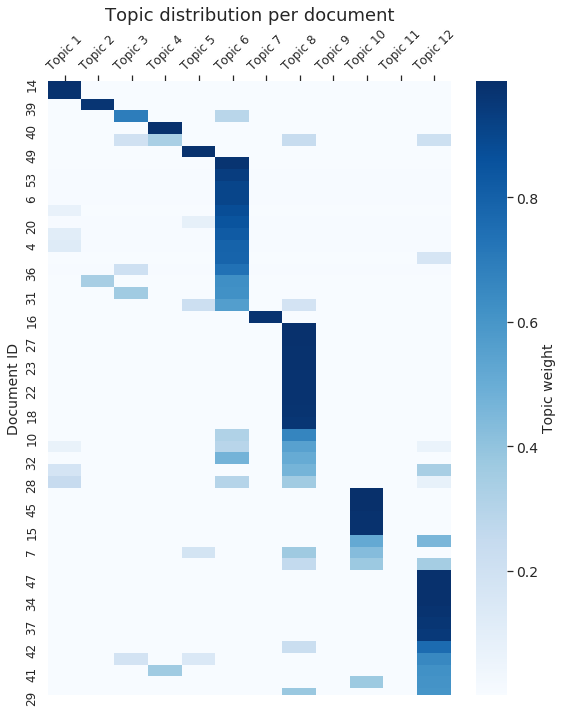

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Count per class:
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 11]), array([ 2,  1,  1,  2,  1, 13,  1, 14,  7, 12]))
Number of terms: 236


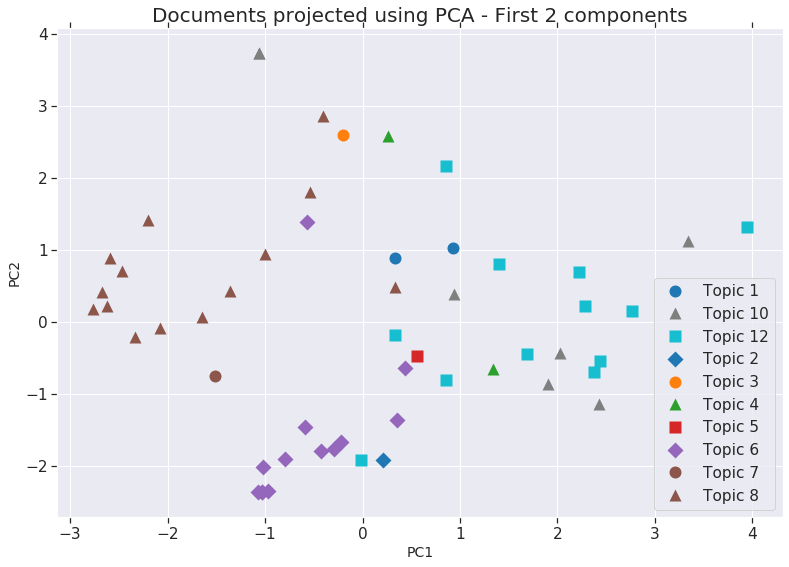

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


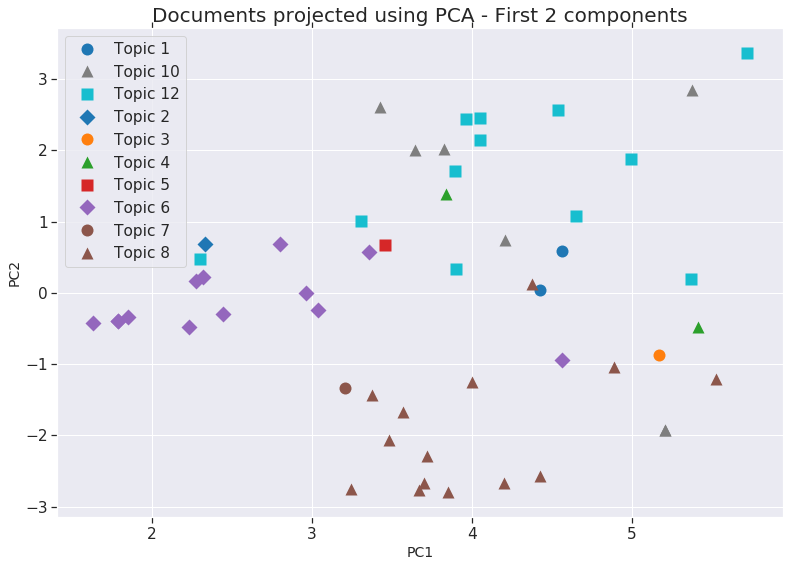

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


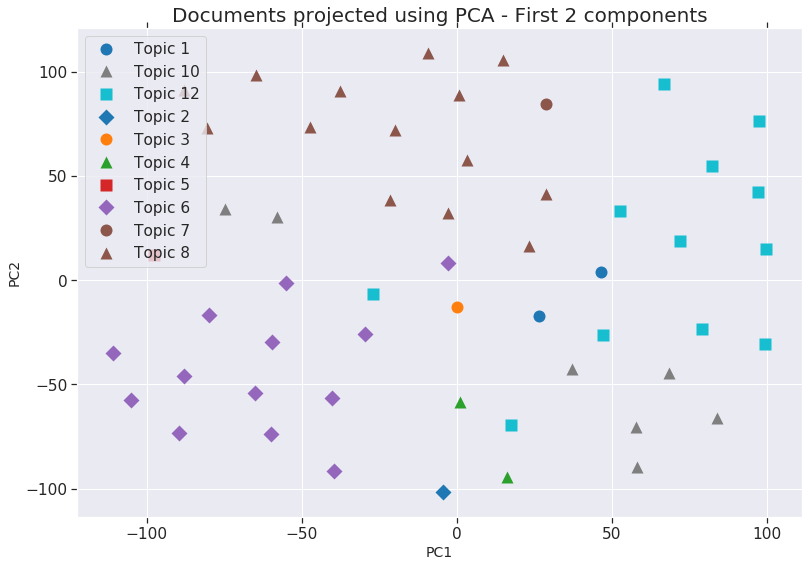

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


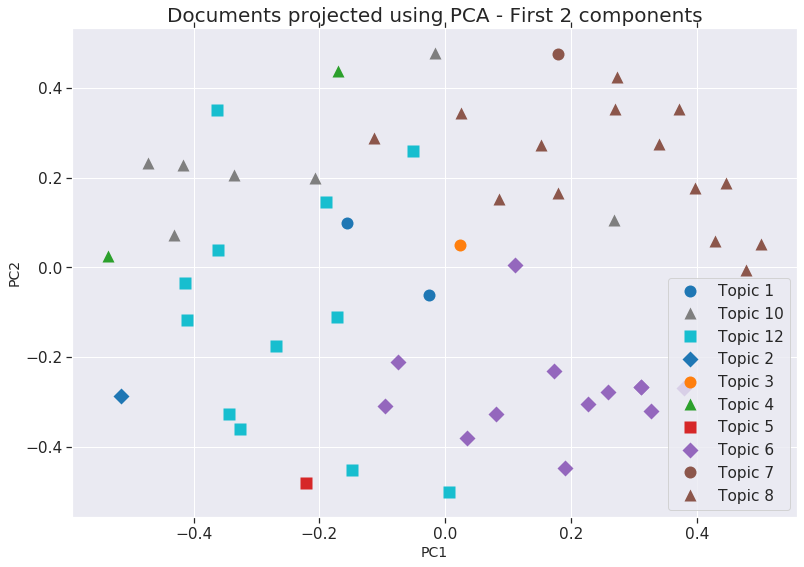

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

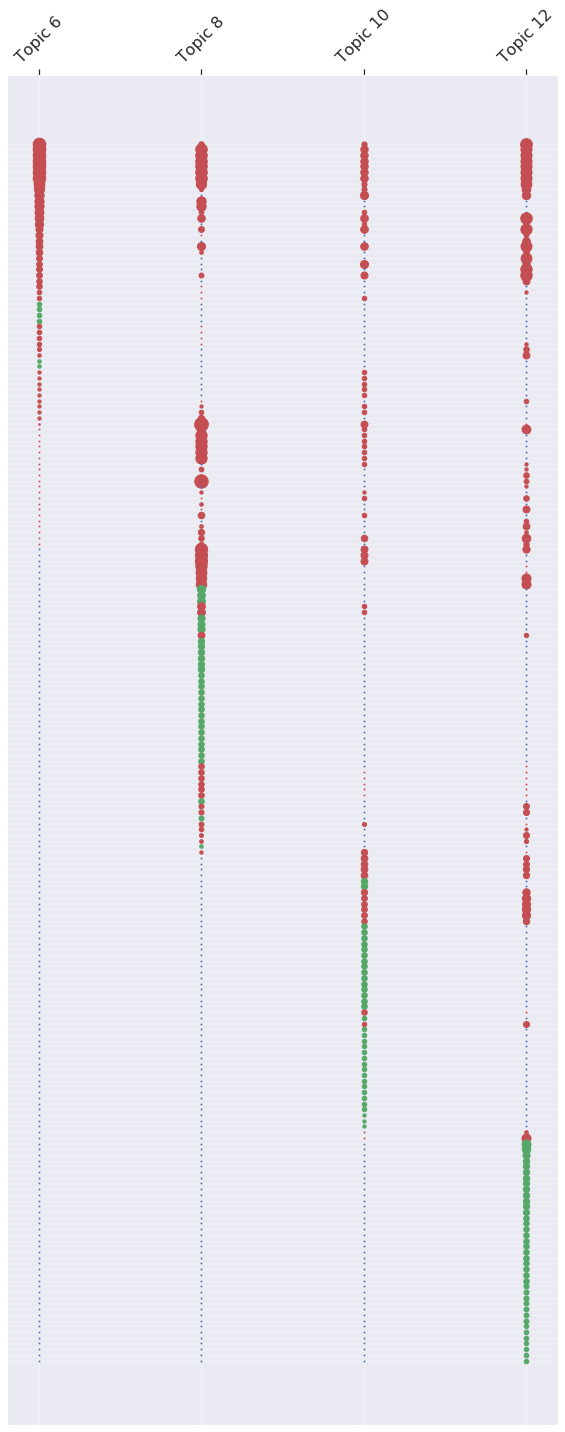

Topic #0: is_op_logic is_number is_block, is_op_logic is_number, is_dedent return, is_op_arit is_number, number is_op_logic, number is_op_logic is_number, is_attribution is_string is_dedent, is_list is_number, str, if
Topic #1: is_string is_class, return is_string, return is_string is_class, join, is_string is_class join, is_class join, is_string, is_class split, split, is_class
Topic #2: is_dedent elif, elif, if, is_op_logic, is_string is_block is_indent, is_op_logic is_string is_block, is_op_logic is_string, is_indent import, is_block is_indent import, import
Topic #3: split, is_class split, is_class split is_string, items is_attribution, items, split is_string, in items is_block, items is_block is_indent, items is_block, in items
Topic #4: for item in, item in, for item, item, amount, for, in, is_number, is_list, is_string is_block
Topic #5: is_op_arit, def, is_block is_indent, return, is_indent, is_block, is_dedent, is_number, is_op_arit is_number, is_list
Topic #6: is_dedent is_de

/data2/miniconda3/envs/machineteaching/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.022341  0.109736       1        1   6.368478
1     -0.022879 -0.166731       2        1   1.935966
2      0.232916  0.055510       3        1   4.170888
3     -0.016688 -0.199473       4        1   4.655772
4     -0.055422 -0.008735       5        1   3.191971
5     -0.226602  0.094721       6        1  12.781302
6      0.016286  0.037668       7        1   1.805723
7      0.074272  0.138742       8        1  25.873921
8      0.067090 -0.037961       9        1   0.221734
9      0.006686 -0.005679      10        1  14.130031
10     0.067090 -0.037961      11        1   0.221734
11    -0.120410  0.020162      12        1  24.642480, topic_info=    Category       Freq                    Term      Total  loglift  logprob
156  Default  25.000000             is_op_logic  25.000000  30.0000  30.0000
37   Default  30.000000                      if  30.000000  29.0000  29.0000
162  Default  23.000000               is_string  23.000000  28.0000  28.0000
109  Default  21.000000            is_indent if  21.000000  27.0000  27.0000
70   Default  21.000000   is_block is_indent if  21.000000  26.0000  26.0000
..       ...        ...                     ...        ...      ...      ...
140  Topic12   5.686409    is_number is_op_arit  13.419810   0.5420  -4.4414
121  Topic12   6.598761                 is_list  26.165715   0.0231  -4.2926
57   Topic12   5.161669  is_attribution is_list  14.219883   0.3873  -4.5382
79   Topic12   5.030493                is_class  19.539944   0.0438  -4.5640
94   Topic12   5.037752     is_dedent is_dedent  28.411149  -0.3291  -4.5625

[600 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
0         7  0.140762            False
0         8  0.844573            False
1         7  0.191909  False is_dedent
1         8  0.767638  False is_dedent
2         7  0.140762             True
...     ...       ...              ...
233       8  0.290717            while
234       4  0.230320             word
234       6  0.460640             word
234      12  0.230320             word
235      12  0.836776                x

[566 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

In [39]:
# Get experiment conditions
exp_id = 26
where_items = get_where_items(exp_id)
print("Conditions")
print(where_items[0][0:7])

clustering, method, feature_names, model = analyze(solutions, where_items, exp_id)
print("Number of terms: %d" % clustering.X.shape[1])
sample, y = plot_reduction(clustering, method, exp_id)
# pdf(sample, y, clustering, method, exp_id)
# plot_words_per_topic(clustering, feature_names, exp_id, size=10, figsize=(10,22))
# plot_words_per_topic(clustering, feature_names, exp_id, size=10, figsize=(8,20), topics=[5,7,9,11], cutoff=True, ylabel=False)
plot_words_per_topic(clustering, feature_names, exp_id, size=10, figsize=(8,20), topics=[5,7,9,11], cutoff=True, 
                     ylabel=False, mark_exclusive=True)
print_top_words(clustering.model, feature_names, 10)
panel = LDAvis(solutions, where_items, model, R=30)
panel

In [40]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy

def _df_with_names(data, index_name, columns_name):
    if type(data) == pd.DataFrame:
        # we want our index to be numbered
        df = pd.DataFrame(data.values)
    else:
        df = pd.DataFrame(data)
    df.index.name = index_name
    df.columns.name = columns_name
    return df

def _series_with_name(data, name):
    if type(data) == pd.Series:
        data.name = name
        # ensures a numeric index
        return data.reset_index()[name]
    else:
        return pd.Series(data, name=name)

def _jensen_shannon(_P, _Q):
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

def js_PCoA(distributions):
    """Dimension reduction via Jensen-Shannon Divergence & Principal Coordinate Analysis
    (aka Classical Multidimensional Scaling)
    Parameters
    ----------
    distributions : array-like, shape (`n_dists`, `k`)
        Matrix of distributions probabilities.
    Returns
    -------
    pcoa : array, shape (`n_dists`, 2)
    """
    dist_matrix = squareform(pdist(distributions, metric=_jensen_shannon))
    return dist_matrix

def _pcoa(pair_dists, n_components=2):
    """Principal Coordinate Analysis,
    aka Classical Multidimensional Scaling
    """
    # code referenced from skbio.stats.ordination.pcoa
    # https://github.com/biocore/scikit-bio/blob/0.5.0/skbio/stats/ordination/_principal_coordinate_analysis.py

    # pairwise distance matrix is assumed symmetric
    pair_dists = np.asarray(pair_dists, np.float64)

    # perform SVD on double centred distance matrix
    n = pair_dists.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    B = - H.dot(pair_dists ** 2).dot(H) / 2
    eigvals, eigvecs = np.linalg.eig(B)

    # Take first n_components of eigenvalues and eigenvectors
    # sorted in decreasing order
    ix = eigvals.argsort()[::-1][:n_components]
    eigvals = eigvals[ix]
    eigvecs = eigvecs[:, ix]

    # replace any remaining negative eigenvalues and associated eigenvectors with zeroes
    # at least 1 eigenvalue must be zero
    eigvals[np.isclose(eigvals, 0)] = 0
    if np.any(eigvals < 0):
        ix_neg = eigvals < 0
        eigvals[ix_neg] = np.zeros(eigvals[ix_neg].shape)
        eigvecs[:, ix_neg] = np.zeros(eigvecs[:, ix_neg].shape)

    return np.sqrt(eigvals) * eigvecs

v = eval(where_items[0][0])
m = where_items[0][1]
b = where_items[0][2]
dist = where_items[0][3]
method = where_items[0][4]
k = where_items[0][6]
model_db = pickle.loads(base64.b64decode(where_items[0][7]))
X = np.asarray(where_items[0][8])

vectorizer = CountVectorizer(analyzer = python_analyzer,
                             binary=b,
                             min_df=m)
train_data_features = vectorizer.fit_transform(solutions)
data = pyLDAvis.sklearn._extract_data(model, train_data_features, vectorizer)

topic_term_dists = _df_with_names(data['topic_term_dists'], 'topic', 'term')
doc_topic_dists = _df_with_names(data['doc_topic_dists'], 'doc', 'topic')
term_frequency = _series_with_name(data['term_frequency'], 'term_frequency')
doc_lengths = _series_with_name(data['doc_lengths'], 'doc_length')
vocab = _series_with_name(data['vocab'], 'vocab')
#pyLDAvis._input_validate(topic_term_dists, doc_topic_dists, doc_lengths, vocab, term_frequency)
#R = min(R, len(vocab))

topic_freq = (doc_topic_dists.T * doc_lengths).T.sum()
# topic_freq       = np.dot(doc_topic_dists.T, doc_lengths)
# if (sort_topics):
#     topic_proportion = (topic_freq / topic_freq.sum()).sort_values(ascending=False)
# else:
topic_proportion = (topic_freq / topic_freq.sum())

topic_order = topic_proportion.index

dist_matrix = js_PCoA(topic_term_dists)
topic_coordinates = _pcoa(dist_matrix)

In [41]:
df = pd.DataFrame(dist_matrix, columns=range(1,13))
df = df.set_index([pd.Index(range(1,13))])
# df_filter = df.loc[[2,4,6,8,10,12]][[2,4,6,8,10,12]]
df_filter = df.loc[[4,6,8,10,12]][[4,6,8,10,12]]
df_filter

,4,6,8,10,12
4,0.000000,0.381368,0.374287,0.289536,0.326664
6,0.381368,0.000000,0.351869,0.316466,0.260271
8,0.374287,0.351869,0.000000,0.335629,0.377956
10,0.289536,0.316466,0.335629,0.000000,0.305758
12,0.326664,0.260271,0.377956,0.305758,0.000000


In [42]:
d_matrix = df_filter.to_numpy()[np.triu_indices(df_filter.shape[0],1)]
# d_matrix.sort()
d_matrix

array([0.38136827, 0.37428716, 0.28953635, 0.32666358, 0.3518686 ,
       0.31646647, 0.26027103, 0.33562852, 0.37795591, 0.30575818])

In [43]:
import scipy.spatial as sp
# import scipy.cluster.hierarchy as hc
import scipy.cluster._hierarchy as hc2
# linkage = hc.linkage(df_filter[[2,4]], method='single')
linkage = hc2.mst_single_linkage(d_matrix, df_filter.shape[0])
linkage

array([[1.        , 4.        , 0.26027103, 2.        ],
       [0.        , 3.        , 0.28953635, 2.        ],
       [5.        , 6.        , 0.30575818, 4.        ],
       [2.        , 7.        , 0.33562852, 5.        ]])

<Figure size 576x504 with 0 Axes>

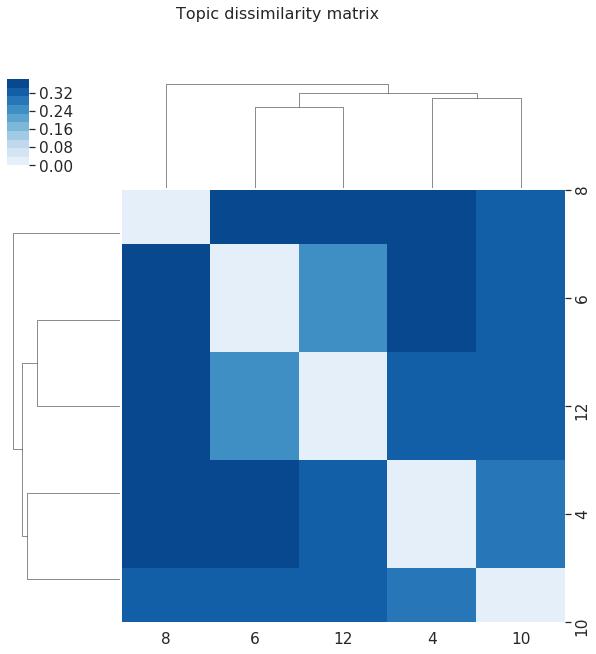

In [44]:
cmap = (sns.color_palette("Blues", 10))
plt.figure(figsize=(8,7))

sns.set(font_scale=1.4) 
g = sns.clustermap(df_filter, 
#                    robust=True,
                   cmap=cmap,
                   row_linkage=linkage,
                   col_linkage=linkage
                    )
g.fig.suptitle("Topic dissimilarity matrix", fontsize=16)
# plt.yticks(fontsize=14)

plt.savefig("data/tese/topic_distances.eps",format='eps')
plt.savefig("data/tese/topic_distances.png", format='png')
plt.show()

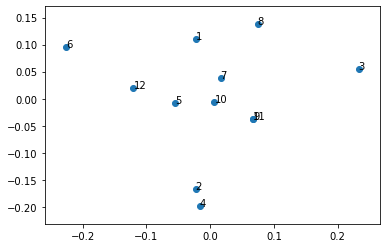

In [24]:
x = topic_coordinates[:,0]
y = topic_coordinates[:,1]
plt.scatter(x,y)

for i in range(12):
    plt.text(x[i],y[i],i+1)

# Experiment 24

- Min DF: 0.05
- Binary: True
- Vectorizer: Count
- Method: NMF
- Best k: 15

In [ ]:
# Get experiment conditions
exp_id = 24
where_items = get_where_items(exp_id)
print("Conditions")
print(where_items[0][0:7])

clustering, method, feature_names, model = analyze(solutions, where_items, exp_id)
sample, y = plot_reduction(clustering, method, exp_id)
pdf(sample, y, clustering, method, exp_id)
plot_words_per_topic(clustering, feature_names, exp_id, size=10, figsize=(10,22))
# plot_words_per_topic(clustering, feature_names, exp_id, size=10, figsize=(10,60), topics=[2,5,7,9,11], cutoff=True)
print_top_words(clustering.model, feature_names, 10)
panel = LDAvis(solutions, where_items, model)
panel